# Tutorial 3: The Numerical Sandbox, Extension Experiment (Static mesh version)

**Romain Beucher** romain.beucher (at) anu.edu.au

The following notebook is an implementation of the Numerical Sandbox Extension Experiment similar to [Buiter et al., 2006](http://sp.lyellcollection.org/content/253/1/29). The test is commonly referred as one of the GEOMOD benchmarks and is used to test the large deformation viscous-plastic behaviour of geodynamic numerical codes.

The initial purpose of the GEOMOD numerical experiments was to compare results from analog and numerical experiments. It is not a numerical benchmark sensus-stricto.

The test has been implemented using Fantom in [Thieulot, 2011](http://linkinghub.elsevier.com/retrieve/pii/S0031920111001336) and more recently with Aspect in [Glerum et al., 2017](http://www.solid-earth-discuss.net/se-2017-9). 

![title](images/underworld.png)

Results for Underworld from this notebook

A | B
- | - 
![title](images/ExtensionA.png) | ![title](images/ExtensionB.png) 

Results for the extension experiment after 2cm extension (Buiter et al., 2006)

In [1]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis

loaded rc file /home/romain/Projects/Project_UWGeodynamics/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
velocity = 2.5 * u.centimeter / u.hour
model_length = 20. * u.centimeter
bodyforce = 1560 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

# Model Geometry

Set-up of the extension experiment. A viscous layer (PDMS, 10 x 0.5 cm) lies in the central part of the model on the base. The rest of the model consists of three ‘sand’ layers (only differing in colour). Extension is achieved by moving the right wall with the attached 10 cm long sheet outwards to the right.

<img src="images/Extension.png" width=800>

We use a uniform resolution of 0.2 cm (400 x 100 elements)

In [4]:
Model = GEO.Model(elementRes=(200, 50), 
                  minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                  maxCoord=(20. * u.centimeter, 1.5 * u.centimeter), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
Model.outputDir="outputs_tutorial3"

In [6]:
Model.add_visugrid(elementRes=(100, 25), 
                   minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                   maxCoord=(20. * u.centimeter, 0.0 * u.centimeter))

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [7]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=Model.bottom))
sand1 = Model.add_material(name="Sand1", shape=GEO.shapes.Layer2D(top=0.*u.centimeter, bottom=Model.bottom))
sand2 = Model.add_material(name="Sand2", shape=GEO.shapes.Layer2D(top=-1. * u.centimeter, bottom=-2. * u.centimeter))

vertices = [( 5.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.5 * u.centimeter),
            ( 5.* u.centimeter, -3.5 * u.centimeter)]

silicon = Model.add_material(name="Silicon", shape=GEO.shapes.Polygon(vertices))

## Passive Tracers

In [8]:
import numpy as np

npoints = 1000

coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = GEO.nd(sand1.top)

Model.add_passive_tracers(name="Interface1", vertices=coords)

coords[:, 1] = GEO.nd(sand2.top)
Model.add_passive_tracers(name="Interface2", vertices=coords)

coords[:, 1] = GEO.nd(sand2.bottom)
Model.add_passive_tracers(name="Interface3", vertices=coords)


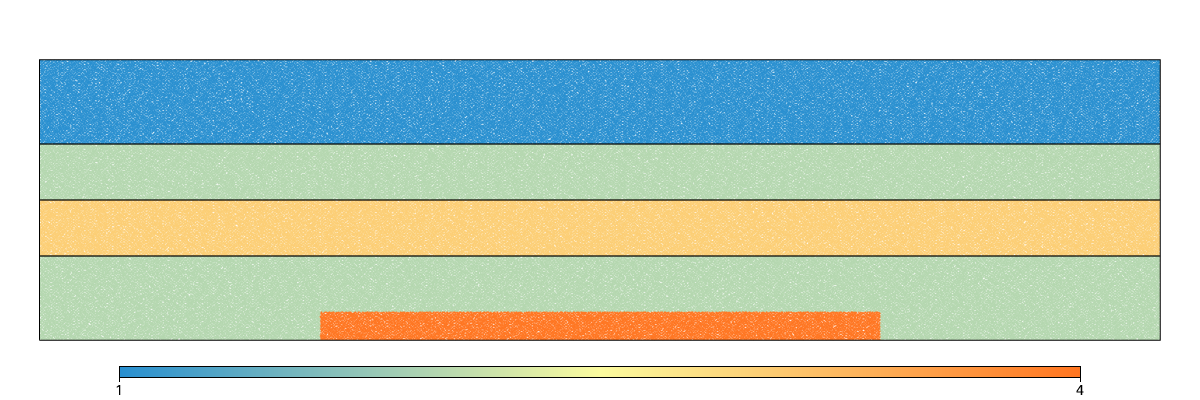

In [10]:
from underworld import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.Interface1_tracers, pointSize=2.0)
Fig.Points(Model.Interface2_tracers, pointSize=2.0)
Fig.Points(Model.Interface3_tracers, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

## Material properties

In [10]:
air.density = 10. * u.kilogram / u.metre**3
sand1.density = 1560. * u.kilogram / u.metre**3
sand2.density = 1560. * u.kilogram / u.metre**3
silicon.density = 965. * u.kilogram / u.metre**3

# Define Viscosities

Viscosities can be defined as a Quantity or a simple scalar value. It is also possible to load predefined rheologies from the rheology_library. 

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [11]:
# Assign function to materials
air.viscosity     = 1.0e2  * u.pascal * u.second
sand1.viscosity   = 1.0e13 * u.pascal * u.second
sand2.viscosity   = 1.0e13 * u.pascal * u.second
silicon.viscosity = 5.0e4  * u.pascal * u.second

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [12]:
sandPlasticity = GEO.DruckerPrager(cohesion=10. * u.pascal,
                                     cohesionAfterSoftening=10. * u.pascal,
                                     frictionCoefficient=0.73,
                                     frictionAfterSoftening=0.60)

In [13]:
sand1.plasticity = sandPlasticity
sand2.plasticity = sandPlasticity

# Boundary conditions

+ Basal points above the moving sheet are assigned the velocity of the sheet
+ Basal points to the left of the moving sheet are held fixed. 
+ The change in velocity at the basal velocity discontinuity is accommodated over 0.2 cm. 
+ The sides are not allowed to move vertically.

In [14]:
import underworld.function as fn

conditions = [(Model.x > GEO.nd(10.1 * u.centimetre), GEO.nd(2.5 * u.centimeter / u.hour)),
              (Model.x > GEO.nd(9.9 * u.centimetre), (Model.x - GEO.nd(9.9 * u.centimetre)) * GEO.nd(velocity) / GEO.nd(0.2 * u.centimetre)),
              (True, 0.0)]

fn_condition = fn.branching.conditional(conditions)

Model.set_velocityBCs(left=[0 * u.centimeter / u.hour, None],
                      right=[2.5 * u.centimeter / u.hour, None],
                      bottom=[fn_condition, 0.0])

## Initialise Model

The model is initialize using the *init_model* method which will solve the initial steady state temperature field and the pressure field.

In [15]:
Model.minViscosity = 1.0e2 * u.pascal * u.second
Model.maxViscosity = 1.0e9 * u.pascal * u.second

In [16]:
Model.init_model(pressure="lithostatic")

/home/romain/Projects/Project_Surface_processes/UWGeodynamics/UWGeodynamics/_model.py:1524: UserWarning: You have not passed anything to the temperature argument. The temperature field will not be initialised
  warnings.warn("You have not passed anything to the temperature argument. The temperature field will not be initialised")



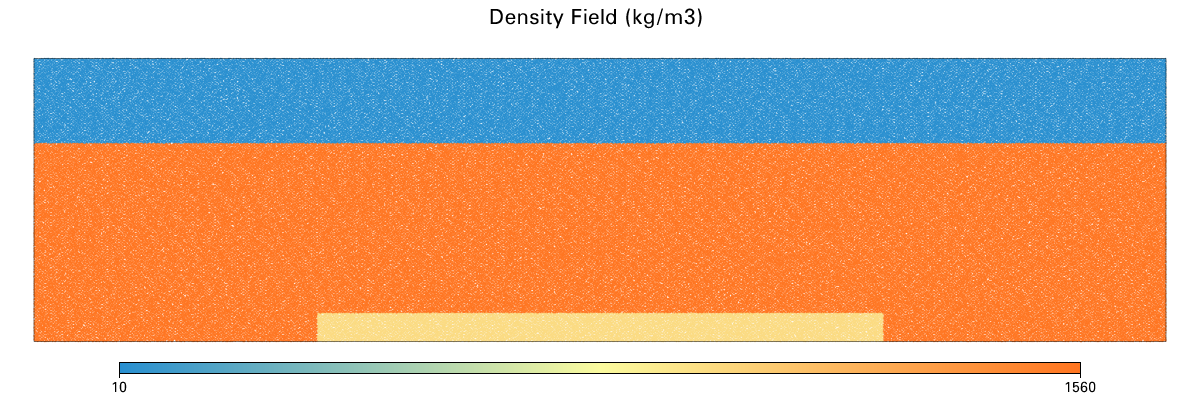

In [17]:
FigDensity = vis.Figure(figsize=(1200, 400), title="Density Field (kg/m3)", quality=3)
FigDensity.Points(Model.swarm, GEO.dimensionalise(Model.densityField, u.kilogram / u.metre**3), pointSize=2.0)
FigDensity.show()


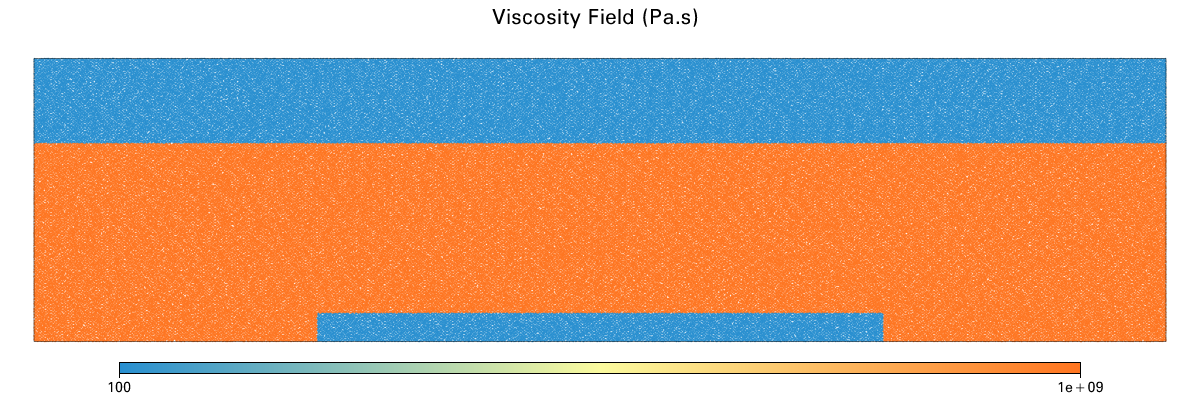

In [18]:
FigViscosity = vis.Figure(figsize=(1200, 400), title="Viscosity Field (Pa.s)", quality=3)
FigViscosity.Points(Model.swarm, GEO.dimensionalise(Model.viscosityField, u.pascal * u.second), pointSize=2.0)
FigViscosity.show()

In [19]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

In [ ]:
Model.run_for(1.0 * u.hours, checkpoint_interval=10 * u.minutes)

Running with UWGeodynamics version 0.9.8b-dev-29e4c3b(development)
Step:     1 Model Time: 0.02 hour dt: 1.20 minute (2018-11-28 23:10:08)
Step:     2 Model Time: 0.04 hour dt: 1.20 minute (2018-11-28 23:10:17)
Step:     3 Model Time: 0.06 hour dt: 1.20 minute (2018-11-28 23:10:25)
Step:     4 Model Time: 0.08 hour dt: 1.20 minute (2018-11-28 23:10:33)
Step:     5 Model Time: 0.10 hour dt: 1.20 minute (2018-11-28 23:10:41)
Step:     6 Model Time: 0.12 hour dt: 1.20 minute (2018-11-28 23:10:48)
Step:     7 Model Time: 0.14 hour dt: 1.20 minute (2018-11-28 23:10:56)
Step:     8 Model Time: 0.16 hour dt: 1.20 minute (2018-11-28 23:11:03)
Step:     9 Model Time: 0.17 hour dt: 0.41 minute (2018-11-28 23:11:18)
Step:    10 Model Time: 0.19 hour dt: 1.20 minute (2018-11-28 23:11:26)
Step:    11 Model Time: 0.21 hour dt: 1.20 minute (2018-11-28 23:11:33)
Step:    12 Model Time: 0.23 hour dt: 1.20 minute (2018-11-28 23:11:41)
Step:    13 Model Time: 0.25 hour dt: 1.20 minute (2018-11-28 23:11:4